# Binary Logistic Regression

From the previous NN, we have implemented a neural network to predict the possiblities and now we train the neural network to predict the exact class for example if it is a dog the NN will provide 1 as output and if it is cat it will predict 0 as output.

Changes we need to do :
- Change the `SoftMax` to `Sigmoid` activation function at output layer
- Change the `Categorical Crossentropy` to `Binary Crossentropy` for calculating the loss

In [1]:
import numpy as np

In [2]:
# Sigmoid class
class Activation_Sigmoid:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-self.inputs))
    
    def backward(self,dvalues):
        self.dinputs = dvalues * (1-self.output) * self.output

In [15]:
class Loss:
    def regularization_loss(self,layer):
        regularization_loss = 0
        # Weight Loss
        if layer.weight_regularizer_l1 > 0:
            # sum of absolute values of weights
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if layer.weight_regularizer_l2 > 0:
            # sum of squared values of weights
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
            
        return regularization_loss
    
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [16]:
# Binary Cross Entropy Loss
class Loss_BinaryCrossentropy(Loss):
    def forward(self,y_pred,y_true):
        y_pred_clipped = np.clip(y_pred,1e-7,1 - 1e-7)
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses,axis=-1)
        return sample_losses
    
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        clipped_values = np.clip(dvalues,1e-7,1 - 1e-7)
        self.dinputs = -(y_true / clipped_values - (1- y_true) / (1 - clipped_values)) / outputs
        
        self.dinputs = self.dinputs / samples
        

## Previous code

In [8]:
# Dense Layer
class Layer_Dense:
    def __init__(self,n_inputs,n_neurons,
                 weight_regularizer_l1 = 0,weight_regularizer_l2=0,
                 bias_regularizer_l1 = 0, bias_regularizer_l2 = 0):
        # init of weights and bias
        self.weights = 0.01 * np.random.randn(n_inputs,n_neurons)
        self.biases = np.zeros((1,n_neurons))
        # init the regularization
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
        
        
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights) + self.biases
        
    def backward(self,dvalues):
        # calculating gradients for parameters
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        
        # calculating gradients for regularization
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases 
            
        # gradients on whole values
        self.dinputs = np.dot(dvalues,self.weights.T)
 
# RELU       
class Activation_RELU:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
        
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    def post_update_params(self):
        self.iterations += 1 


## Training

In [7]:
from tqdm import tqdm
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

In [25]:
X,y = spiral_data(samples=100,classes=2)
y = y.reshape(-1,1) # why we are reshaping?

dense1 = Layer_Dense(2,64,weight_regularizer_l1=5e-4,weight_regularizer_l2=5e-4)
activation1 = Activation_RELU()
dense2 = Layer_Dense(64,1)
activation2 = Activation_Sigmoid()
loss_function = Loss_BinaryCrossentropy()
optimizer = Optimizer_Adam(learning_rate=0.01,decay=5e-4)

epoches = []
accuracies = []
losses = []
learning_rates = []

In [26]:
# training loop
for epoch in tqdm(range(10001),desc="Training the model : "):
    # forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    # loss
    data_loss = loss_function.calculate(activation2.output,y)
    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2)
    loss = data_loss + regularization_loss
    
    # predictions
    predictions = (activation2.output > 0.5) * 1
    accuracy = np.mean(predictions==y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
        epoches.append(epoch)
        accuracies.append(accuracy)
        losses.append(loss)
        learning_rates.append(optimizer.current_learning_rate)
        
    # Backward Pass
    loss_function.backward(activation2.output,y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Optimizer step
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

Training the model :   3%|▎         | 287/10001 [00:00<00:03, 2868.75it/s]

epoch: 0, acc: 0.470, loss: 0.694, lr: 0.01
epoch: 100, acc: 0.600, loss: 0.673, lr: 0.009528346831824679
epoch: 200, acc: 0.600, loss: 0.672, lr: 0.009095043201455207
epoch: 300, acc: 0.600, loss: 0.672, lr: 0.008699434536755112
epoch: 400, acc: 0.595, loss: 0.672, lr: 0.008336807002917883
epoch: 500, acc: 0.600, loss: 0.672, lr: 0.008003201280512205


Training the model :   8%|▊         | 848/10001 [00:00<00:03, 2649.99it/s]

epoch: 600, acc: 0.600, loss: 0.672, lr: 0.007695267410542516
epoch: 700, acc: 0.595, loss: 0.672, lr: 0.007410151908114116
epoch: 800, acc: 0.600, loss: 0.672, lr: 0.007145409074669526
epoch: 900, acc: 0.600, loss: 0.672, lr: 0.006898930665746809
epoch: 1000, acc: 0.595, loss: 0.672, lr: 0.006668889629876626


Training the model :  14%|█▎        | 1369/10001 [00:00<00:03, 2265.40it/s]

epoch: 1100, acc: 0.600, loss: 0.672, lr: 0.006453694740238787
epoch: 1200, acc: 0.600, loss: 0.672, lr: 0.006251953735542357
epoch: 1300, acc: 0.600, loss: 0.672, lr: 0.006062443164595333
epoch: 1400, acc: 0.600, loss: 0.672, lr: 0.005884083553986467
epoch: 1500, acc: 0.595, loss: 0.672, lr: 0.0057159188339525584
epoch: 1600, acc: 0.600, loss: 0.672, lr: 0.005557099194220616


Training the model :  19%|█▉        | 1919/10001 [00:00<00:03, 2509.89it/s]

epoch: 1700, acc: 0.600, loss: 0.672, lr: 0.005406866720735334
epoch: 1800, acc: 0.600, loss: 0.672, lr: 0.0052645433008686494
epoch: 1900, acc: 0.600, loss: 0.672, lr: 0.005129520389843549
epoch: 2000, acc: 0.600, loss: 0.672, lr: 0.005001250312578145
epoch: 2100, acc: 0.600, loss: 0.672, lr: 0.0048792388387411565


Training the model :  24%|██▍       | 2414/10001 [00:01<00:03, 2287.22it/s]

epoch: 2200, acc: 0.590, loss: 0.672, lr: 0.004763038818766373
epoch: 2300, acc: 0.600, loss: 0.672, lr: 0.004652244708071645
epoch: 2400, acc: 0.600, loss: 0.672, lr: 0.0045464878381450335
epoch: 2500, acc: 0.600, loss: 0.672, lr: 0.004445432318292954
epoch: 2600, acc: 0.600, loss: 0.672, lr: 0.004348771472059143


Training the model :  32%|███▏      | 3176/10001 [00:01<00:02, 2285.49it/s]

epoch: 2700, acc: 0.600, loss: 0.672, lr: 0.004256224728665673
epoch: 2800, acc: 0.600, loss: 0.672, lr: 0.004167534903104814
epoch: 2900, acc: 0.590, loss: 0.672, lr: 0.004082465809348847
epoch: 3000, acc: 0.595, loss: 0.672, lr: 0.0040008001600320055
epoch: 3100, acc: 0.600, loss: 0.672, lr: 0.003922337713277113
epoch: 3200, acc: 0.600, loss: 0.672, lr: 0.003846893633391037


Training the model :  36%|███▋      | 3646/10001 [00:01<00:02, 2173.15it/s]

epoch: 3300, acc: 0.595, loss: 0.672, lr: 0.0037742970371768265
epoch: 3400, acc: 0.600, loss: 0.672, lr: 0.003704389701796629
epoch: 3500, acc: 0.600, loss: 0.672, lr: 0.003637024913620658
epoch: 3600, acc: 0.600, loss: 0.672, lr: 0.003572066440435792
epoch: 3700, acc: 0.595, loss: 0.672, lr: 0.00350938761186173


Training the model :  42%|████▏     | 4154/10001 [00:01<00:02, 2362.93it/s]

epoch: 3800, acc: 0.595, loss: 0.672, lr: 0.0034488704949129164
epoch: 3900, acc: 0.600, loss: 0.672, lr: 0.003390405153415833
epoch: 4000, acc: 0.600, loss: 0.672, lr: 0.003333888981496916
epoch: 4100, acc: 0.600, loss: 0.672, lr: 0.003279226102639777
epoch: 4200, acc: 0.600, loss: 0.672, lr: 0.0032263268269075657


Training the model :  46%|████▌     | 4613/10001 [00:02<00:02, 2114.86it/s]

epoch: 4300, acc: 0.600, loss: 0.672, lr: 0.0031751071598666455
epoch: 4400, acc: 0.595, loss: 0.672, lr: 0.0031254883575558678
epoch: 4500, acc: 0.595, loss: 0.672, lr: 0.00307739652254193
epoch: 4600, acc: 0.595, loss: 0.672, lr: 0.0030307622367025306
epoch: 4700, acc: 0.600, loss: 0.672, lr: 0.0029855202268995375


Training the model :  51%|█████     | 5121/10001 [00:02<00:02, 2308.14it/s]

epoch: 4800, acc: 0.600, loss: 0.672, lr: 0.0029416090601559054
epoch: 4900, acc: 0.600, loss: 0.672, lr: 0.0028989708653428033
epoch: 5000, acc: 0.600, loss: 0.672, lr: 0.0028575510787255324
epoch: 5100, acc: 0.600, loss: 0.672, lr: 0.0028172982110156357
epoch: 5200, acc: 0.600, loss: 0.672, lr: 0.0027781636338380334


Training the model :  56%|█████▋    | 5644/10001 [00:02<00:01, 2284.89it/s]

epoch: 5300, acc: 0.600, loss: 0.672, lr: 0.0027401013837511983
epoch: 5400, acc: 0.595, loss: 0.672, lr: 0.0027030679821597515
epoch: 5500, acc: 0.595, loss: 0.672, lr: 0.0026670222696359514
epoch: 5600, acc: 0.595, loss: 0.672, lr: 0.0026319252533228057
epoch: 5700, acc: 0.595, loss: 0.672, lr: 0.0025977399662293803


Training the model :  62%|██████▏   | 6164/10001 [00:02<00:01, 2323.45it/s]

epoch: 5800, acc: 0.595, loss: 0.672, lr: 0.0025644313373509426
epoch: 5900, acc: 0.600, loss: 0.672, lr: 0.00253196607165464
epoch: 6000, acc: 0.600, loss: 0.672, lr: 0.002500312539067383
epoch: 6100, acc: 0.600, loss: 0.672, lr: 0.0024694406716878627
epoch: 6200, acc: 0.600, loss: 0.672, lr: 0.0024393218685205514


Training the model :  67%|██████▋   | 6669/10001 [00:02<00:01, 2356.77it/s]

epoch: 6300, acc: 0.595, loss: 0.672, lr: 0.0024099289070972406
epoch: 6400, acc: 0.600, loss: 0.672, lr: 0.0023812358614120725
epoch: 6500, acc: 0.595, loss: 0.672, lr: 0.002353218025650076
epoch: 6600, acc: 0.600, loss: 0.672, lr: 0.002325851843237586
epoch: 6700, acc: 0.600, loss: 0.672, lr: 0.0022991148407862975


Training the model :  72%|███████▏  | 7219/10001 [00:03<00:01, 2550.73it/s]

epoch: 6800, acc: 0.595, loss: 0.672, lr: 0.0022729855665416525
epoch: 6900, acc: 0.600, loss: 0.672, lr: 0.002247443532981234
epoch: 7000, acc: 0.600, loss: 0.672, lr: 0.00222246916324036
epoch: 7100, acc: 0.595, loss: 0.672, lr: 0.0021980437410704474
epoch: 7200, acc: 0.600, loss: 0.672, lr: 0.0021741493640613113
epoch: 7300, acc: 0.600, loss: 0.672, lr: 0.0021507688998817077


Training the model :  78%|███████▊  | 7807/10001 [00:03<00:00, 2751.50it/s]

epoch: 7400, acc: 0.600, loss: 0.672, lr: 0.002127885945313331
epoch: 7500, acc: 0.600, loss: 0.672, lr: 0.0021054847878724074
epoch: 7600, acc: 0.600, loss: 0.672, lr: 0.0020835503698301903
epoch: 7700, acc: 0.600, loss: 0.672, lr: 0.0020620682544592226
epoch: 7800, acc: 0.595, loss: 0.671, lr: 0.002041024594346362
epoch: 7900, acc: 0.600, loss: 0.671, lr: 0.002020406101626427
epoch: 8000, acc: 0.595, loss: 0.672, lr: 0.002000200020002


Training the model :  87%|████████▋ | 8657/10001 [00:03<00:00, 2788.73it/s]

epoch: 8100, acc: 0.600, loss: 0.671, lr: 0.0019803940984255866
epoch: 8200, acc: 0.600, loss: 0.671, lr: 0.0019609765663300325
epoch: 8300, acc: 0.595, loss: 0.671, lr: 0.0019419361103019711
epoch: 8400, acc: 0.595, loss: 0.671, lr: 0.0019232618521011636
epoch: 8500, acc: 0.595, loss: 0.671, lr: 0.0019049433279359938
epoch: 8600, acc: 0.600, loss: 0.671, lr: 0.0018869704689121615


Training the model :  92%|█████████▏| 9237/10001 [00:03<00:00, 2842.28it/s]

epoch: 8700, acc: 0.600, loss: 0.671, lr: 0.001869333582577811
epoch: 8800, acc: 0.600, loss: 0.671, lr: 0.0018520233354940275
epoch: 8900, acc: 0.600, loss: 0.671, lr: 0.0018350307367648406
epoch: 9000, acc: 0.595, loss: 0.671, lr: 0.0018183471224656785
epoch: 9100, acc: 0.600, loss: 0.671, lr: 0.001801964140913596
epoch: 9200, acc: 0.600, loss: 0.671, lr: 0.0017858737387266722
epoch: 9300, acc: 0.595, loss: 0.671, lr: 0.0017700681476236835


Training the model :  98%|█████████▊| 9799/10001 [00:04<00:00, 2674.59it/s]

epoch: 9400, acc: 0.600, loss: 0.671, lr: 0.0017545398719185893
epoch: 9500, acc: 0.600, loss: 0.671, lr: 0.0017392816766675363
epoch: 9600, acc: 0.600, loss: 0.671, lr: 0.0017242865764290024
epoch: 9700, acc: 0.600, loss: 0.671, lr: 0.0017095478246003932
epoch: 9800, acc: 0.600, loss: 0.671, lr: 0.0016950589032968897


Training the model : 100%|██████████| 10001/10001 [00:04<00:00, 2413.74it/s]

epoch: 9900, acc: 0.600, loss: 0.671, lr: 0.0016808135137406505
epoch: 10000, acc: 0.600, loss: 0.671, lr: 0.0016668055671305944


In [27]:
X_test, y_test = spiral_data(samples=100, classes=2)
y_test = y_test.reshape(-1,1)
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output) 
activation2.forward(dense2.output)
loss = loss_function.calculate(activation2.output,y_test)
predictions = (activation2.output > 0.5) * 1
accuracy = np.mean(predictions == y_test)

print(f"Validation acc: {accuracy : .3f}, loss: {loss : .3f}")

Validation acc:  0.615, loss:  0.665


In [22]:
import matplotlib.pyplot as plt

def plot_line_chart(x,y,title,x_label,y_label):
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

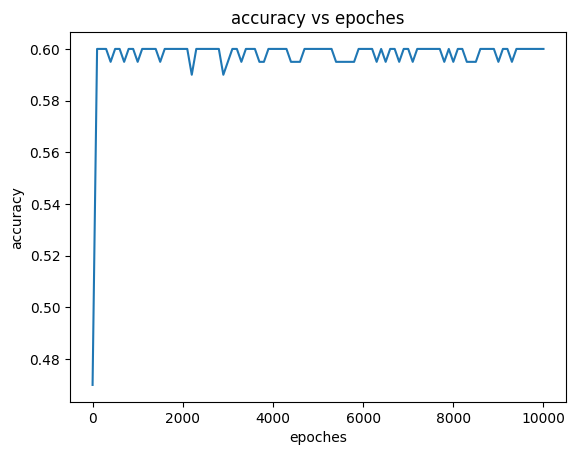

In [28]:
x = epoches
y = accuracies
plot_line_chart(x,y,"accuracy vs epoches","epoches","accuracy")

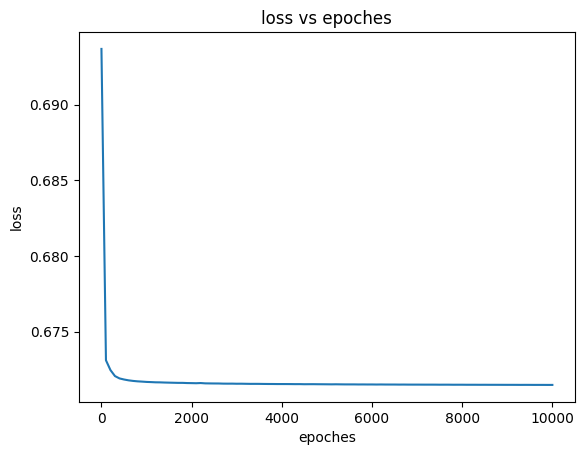

In [29]:
plot_line_chart(x,losses,"loss vs epoches","epoches","loss")